In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

  
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
X = tf.placeholder(tf.float32, shape=[None, 784])
with tf.device('/gpu:0'):
  D_W1 = tf.Variable(xavier_init([784, 128]))
  D_b1 = tf.Variable(tf.zeros(shape=[128]))

  D_W2 = tf.Variable(xavier_init([128, 1]))
  D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


Z = tf.placeholder(tf.float32, shape=[None, 16])
c = tf.placeholder(tf.float32, shape=[None, 10])
with tf.device('/gpu:0'):
  G_W1 = tf.Variable(xavier_init([26, 256]))
  G_b1 = tf.Variable(tf.zeros(shape=[256]))

  G_W2 = tf.Variable(xavier_init([256, 784]))
  G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

with tf.device('/gpu:0'):
  Q_W1 = tf.Variable(xavier_init([784, 128]))
  Q_b1 = tf.Variable(tf.zeros(shape=[128]))

  Q_W2 = tf.Variable(xavier_init([128, 10]))
  Q_b2 = tf.Variable(tf.zeros(shape=[10]))

theta_Q = [Q_W1, Q_W2, Q_b1, Q_b2]

In [0]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def sample_c(m):
    return np.random.multinomial(1, 10*[0.1], size=m)


def generator(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob


def Q(x):
    Q_h1 = tf.nn.relu(tf.matmul(x, Q_W1) + Q_b1)
    Q_prob = tf.nn.softmax(tf.matmul(Q_h1, Q_W2) + Q_b2)

    return Q_prob


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig


In [5]:
with tf.device('/gpu:0'):
  G_sample = generator(Z, c)
  D_real = discriminator(X)
  D_fake = discriminator(G_sample)
  Q_c_given_x = Q(G_sample)
with tf.device('/gpu:0'):
  D_loss = -tf.reduce_mean(tf.log(D_real + 1e-8) + tf.log(1 - D_fake + 1e-8))
  G_loss = -tf.reduce_mean(tf.log(D_fake + 1e-8))
with tf.device('/gpu:0'):
  cross_ent = tf.reduce_mean(-tf.reduce_sum(tf.log(Q_c_given_x + 1e-8) * c, 1))
  ent = tf.reduce_mean(-tf.reduce_sum(tf.log(c + 1e-8) * c, 1))
  Q_loss = cross_ent + ent

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=theta_G + theta_Q)

mb_size = 32
Z_dim = 16

mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


Iter: 0
D loss: 1.174
G_loss: 1.449
------------------------------------
Iter: 10000
D loss: 0.882
G_loss: 1.562
------------------------------------


/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter: 20000
D loss: 1.153
G_loss: 1.262
------------------------------------
Iter: 30000
D loss: 1.179
G_loss: 1.01
------------------------------------
Iter: 40000
D loss: 0.9036
G_loss: 1.684
------------------------------------
Iter: 50000
D loss: 0.9103
G_loss: 1.603
------------------------------------
Iter: 60000
D loss: 0.8191
G_loss: 1.577
------------------------------------
Iter: 70000
D loss: 0.9719
G_loss: 1.544
------------------------------------
Iter: 80000
D loss: 1.018
G_loss: 1.186
------------------------------------
Iter: 90000
D loss: 0.8956
G_loss: 1.492
------------------------------------


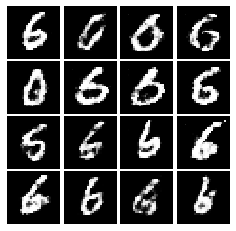

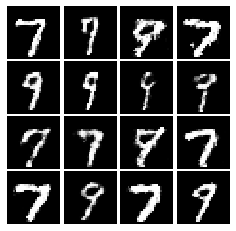

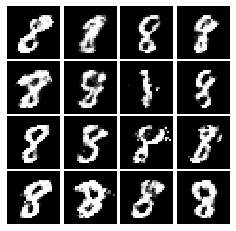

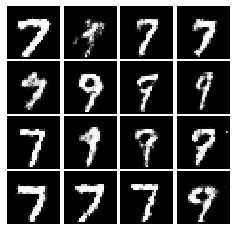

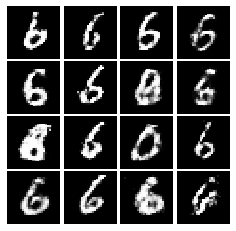

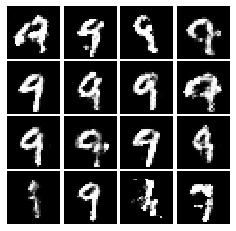

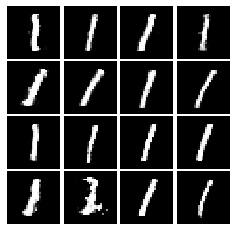

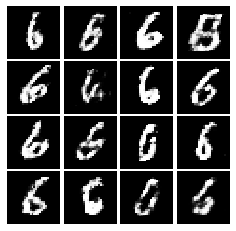

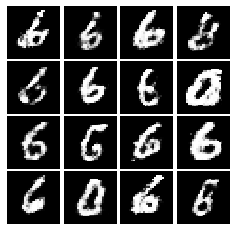

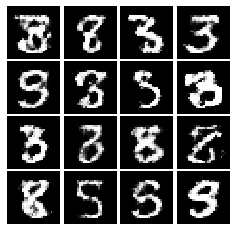

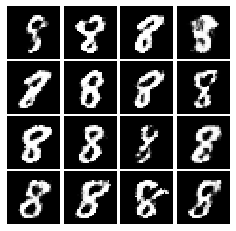

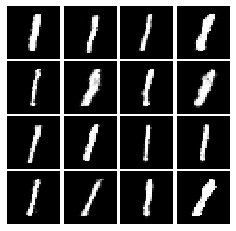

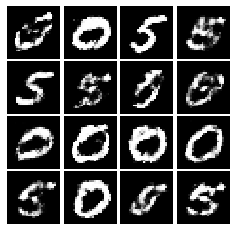

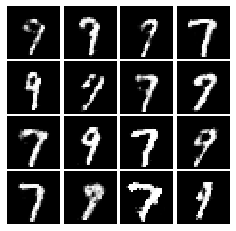

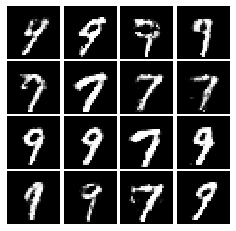

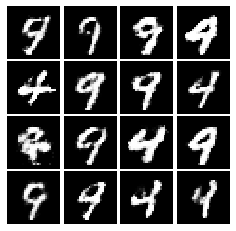

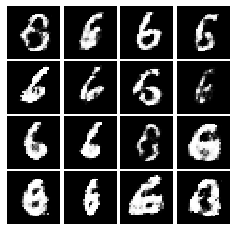

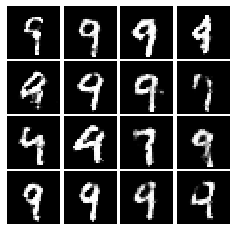

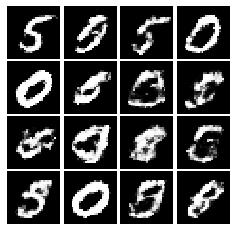

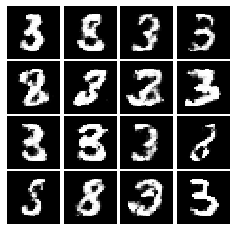

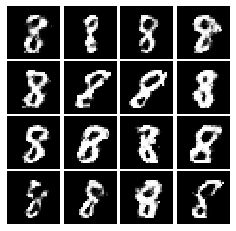

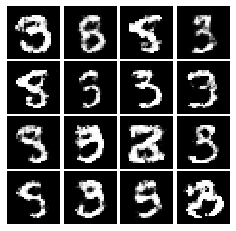

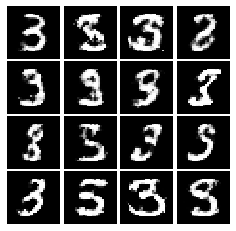

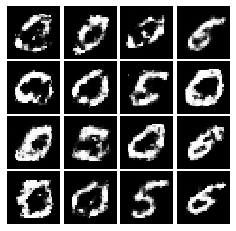

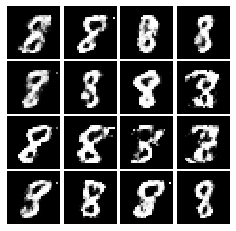

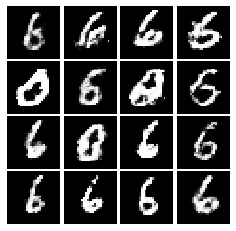

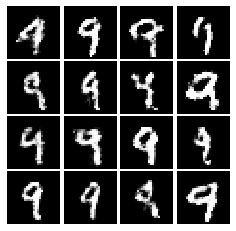

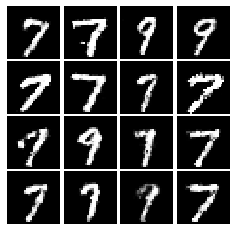

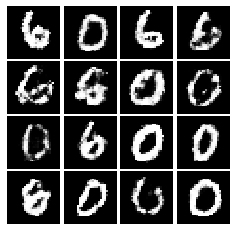

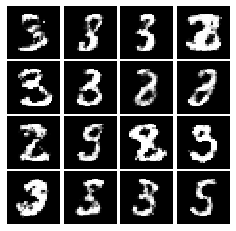

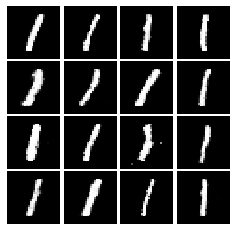

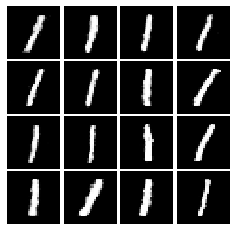

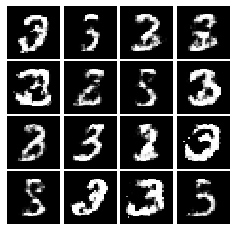

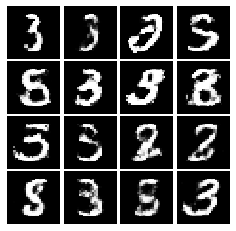

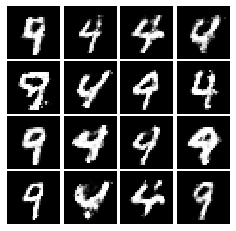

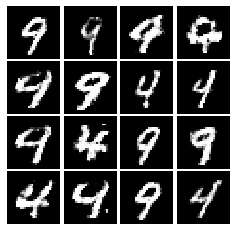

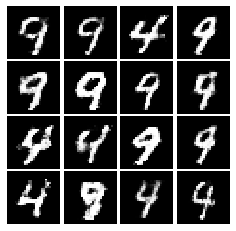

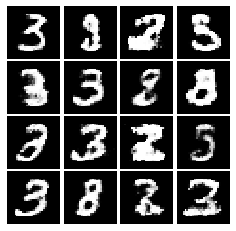

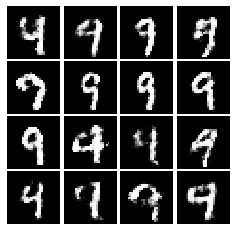

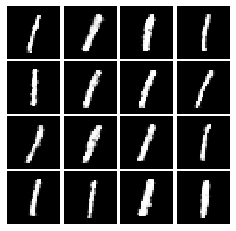

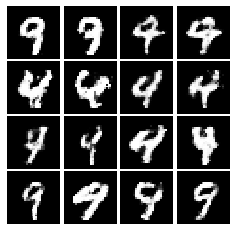

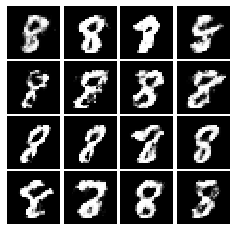

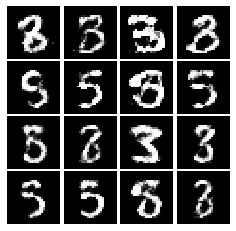

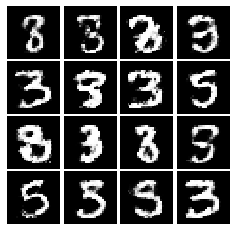

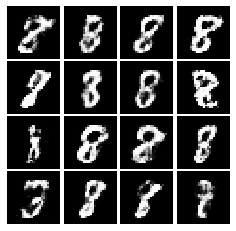

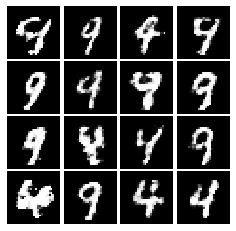

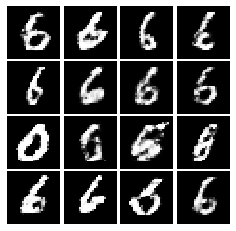

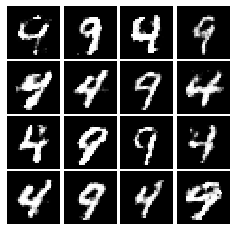

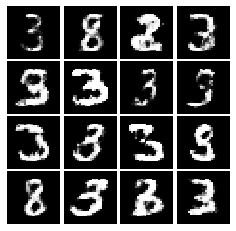

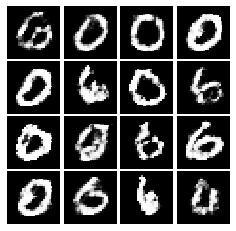

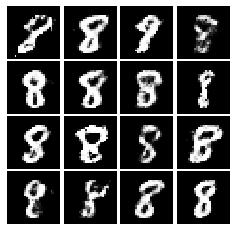

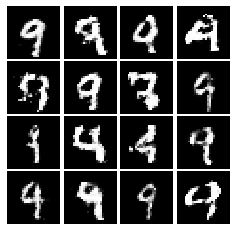

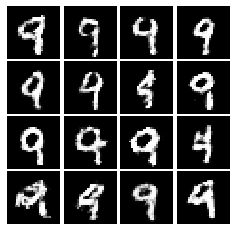

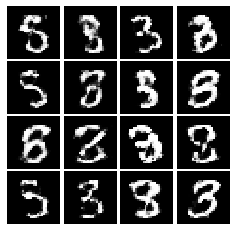

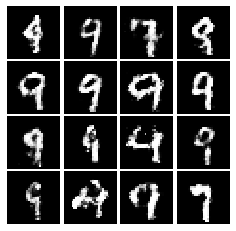

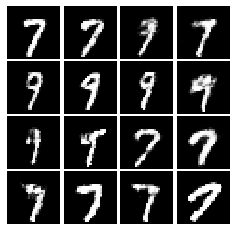

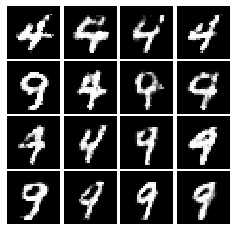

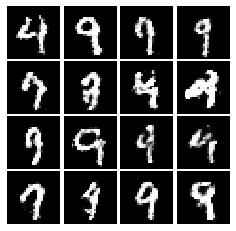

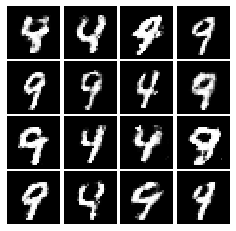

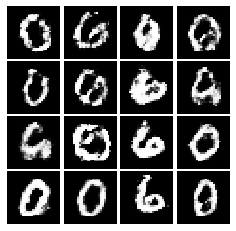

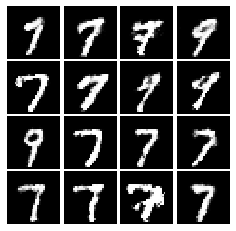

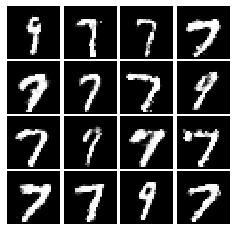

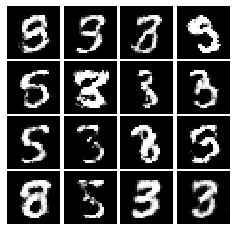

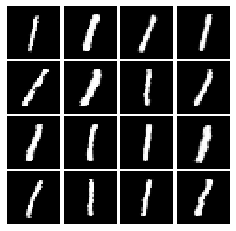

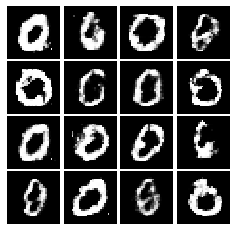

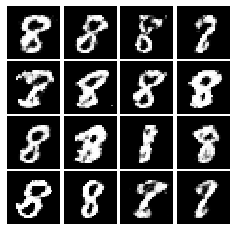

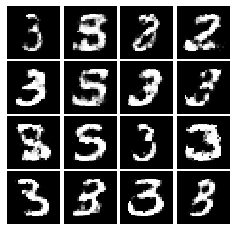

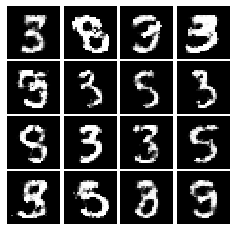

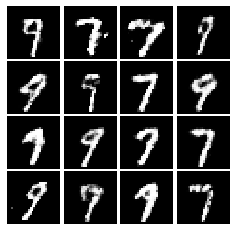

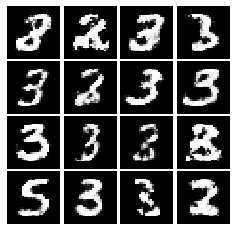

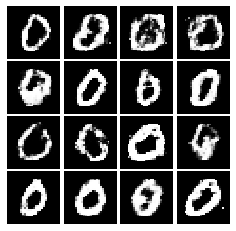

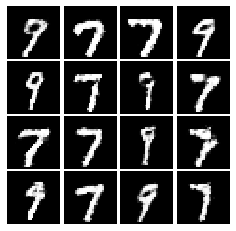

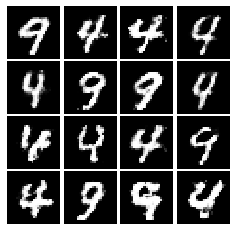

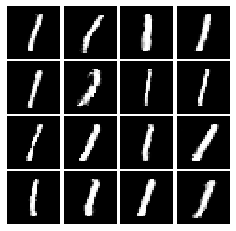

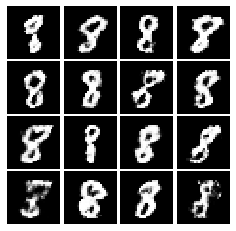

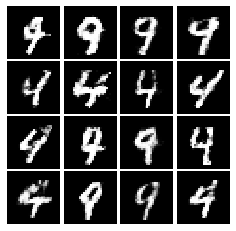

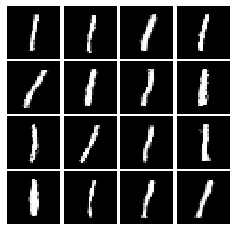

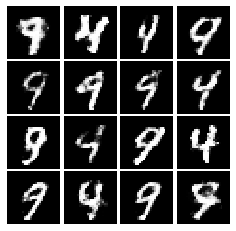

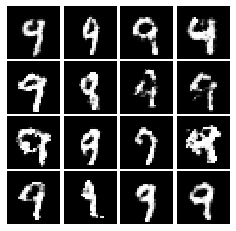

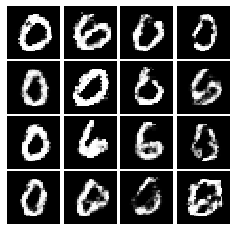

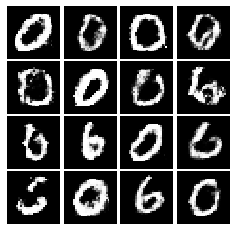

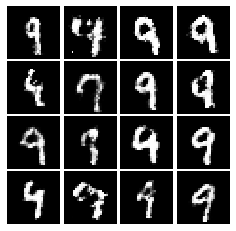

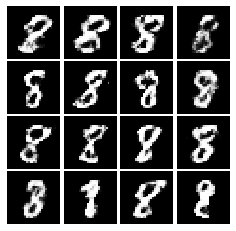

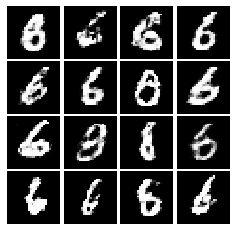

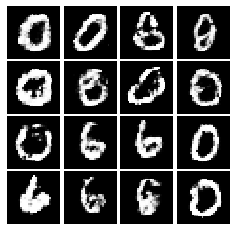

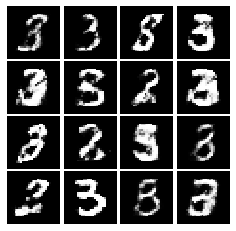

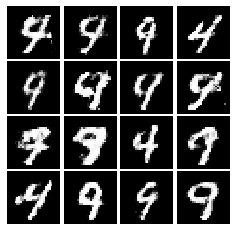

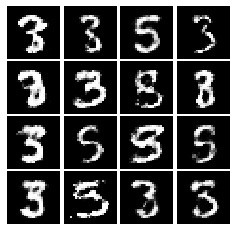

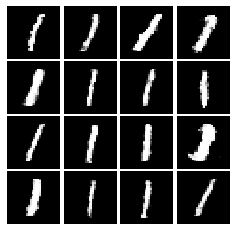

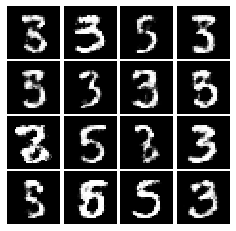

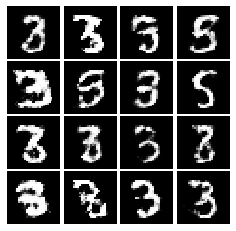

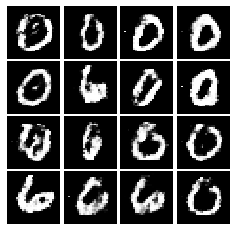

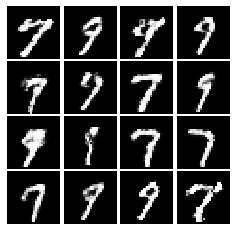

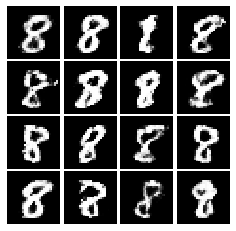

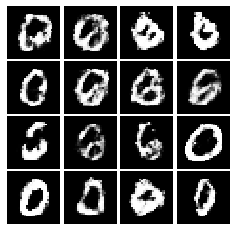

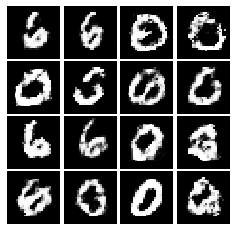

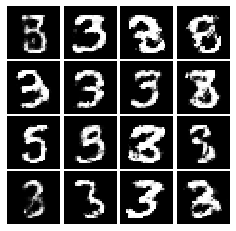

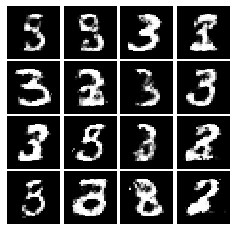

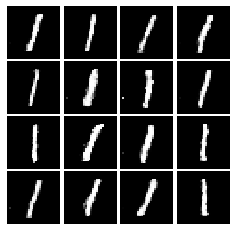

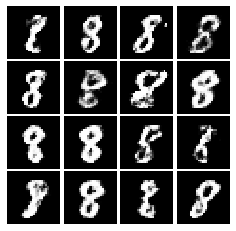

In [7]:
i = 0

for it in range(100000):
    if it % 1000 == 0:
        Z_noise = sample_Z(16, Z_dim)

        idx = np.random.randint(0, 10)
        c_noise = np.zeros([16, 10])
        c_noise[range(16), idx] = 1

        samples = sess.run(G_sample,
                           feed_dict={Z: Z_noise, c: c_noise})

        fig = plot(samples)
        plt.savefig('{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        # plt.close(fig)

    X_mb, _ = mnist.train.next_batch(mb_size)
    Z_noise = sample_Z(mb_size, Z_dim)
    c_noise = sample_c(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss],
                              feed_dict={X: X_mb, Z: Z_noise, c: c_noise})

    _, G_loss_curr = sess.run([G_solver, G_loss],
                              feed_dict={Z: Z_noise, c: c_noise})

    sess.run([Q_solver], feed_dict={Z: Z_noise, c: c_noise})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print("------------------------------------")